# Import librairies

In [240]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.mixture import GaussianMixture
import tensorflow as tf
from sklearn.model_selection import train_test_split


from tensorflow.keras.layers import (
    Input,
    Embedding,
    Concatenate,
    Flatten,
    Dense,
    Dropout,
    concatenate,
)
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam

# Import data

In [2]:
path = "../data"
df = pd.read_csv(os.path.join(path,"cleaned_dataset.csv"),index_col=0)

In [102]:
df = df[df["basesalary"]<=2*df["basesalary"].mean()]

# Add gaussian noise by columns

In [105]:
noises_std={}
for col in df.columns:
    noises_std[col] = df[col].std()    

In [106]:
df2 = df.copy()

In [107]:
for col in df2.columns:
    df2[col]=df2[col]+np.random.normal(0,noises_std[col],len(df))

In [108]:
X = df2.drop(columns=["basesalary"])
y = df2["basesalary"]

In [109]:
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0, max_depth=10)
regressor.fit(X, y) 
y_pred = regressor.predict(X)
rmse = float(format(np.sqrt(mean_squared_error(y, y_pred)), '.3f'))
print("\nRMSE: ", rmse)


RMSE:  47122.597


In [110]:
y_pred = regressor.predict(df.drop(columns=["basesalary"]))
rmse = float(format(np.sqrt(mean_squared_error(df["basesalary"], y_pred)), '.3f'))
print("\nRMSE: ", rmse)


RMSE:  28458.664


In [111]:
pd.concat([df2["yearsofexperience"],df["yearsofexperience"]],axis=1).corr()

,yearsofexperience,yearsofexperience
yearsofexperience,1.000000,0.708437
yearsofexperience,0.708437,1.000000


# Add gaussian noise by rows

# Gaussian mixture

In [113]:
gm = GaussianMixture(n_components=20, random_state=0,covariance_type='diag').fit(df)

In [114]:
df_sample = gm.sample(50000)[0]
y_gaussian = df_sample[:,3]
x_gaussian = df_sample[:,[i for i in range(len(df.columns)) if i!=3]]
regressor = RandomForestRegressor(n_estimators = 30, random_state = 0, max_depth=10)
regressor.fit(x_gaussian, y_gaussian) 

RandomForestRegressor(max_depth=10, n_estimators=30, random_state=0)

In [115]:
rmse = float(format(np.sqrt(mean_squared_error(y, y_pred)), '.3f'))
print("\nRMSE: ", rmse)


RMSE:  48668.581


In [116]:
y_pred = regressor.predict(df.drop(columns=["basesalary"]))
rmse = float(format(np.sqrt(mean_squared_error(df["basesalary"], y_pred)), '.3f'))
print("\nRMSE: ", rmse)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(



RMSE:  160890.363


In [117]:
df["basesalary"].mean()

155892.7930736961

# Word embedding and then gaussian mixture

In [224]:
path = "../data"
df = pd.read_csv(os.path.join(path,"data_with_missing.csv"),index_col=0)
features_to_keep = ["company","level","title","location","yearsofexperience","yearsatcompany","gender","year","tag","tag_truncated","country"]
label =["basesalary"]
df = df[features_to_keep+label]
df.loc[df["level"].isin(df["level"].value_counts()[df["level"].value_counts()<=50].keys().tolist()),"level"]="other"
df.loc[df["tag"].isin(df["tag"].value_counts()[df["tag"].value_counts()<=50].keys().tolist()),"tag"]="other"

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [225]:
#for column in ["tag","tag_truncated"]:
#   df[column]=df[column].apply(lambda x: df[column].mode().tolist()[0] if pd.isnull(x) else x)
df["year"]=df["year"].apply(lambda x: x if pd.isnull(x) else x[:4])
df = df[df["basesalary"]!=0]
df = df[df["basesalary"]<=2*df["basesalary"].mean()]

In [226]:
ohe_features=["title","location","gender","year","country"]
textual_features=["company","level","tag","tag_truncated"]
numeric_features=["yearsofexperience","yearsatcompany"]
label=["basesalary"]
df=df[ohe_features+textual_features+numeric_features+label]

In [227]:
for feature in textual_features:
    df.loc[pd.isnull(df[feature]),feature]="Unavailable"

In [228]:
vocab = {}

# textual_feature =
for feature in textual_features:
    df[feature]=df[feature]
    vocab[feature] = {
        k: v for v, k in enumerate(np.unique(df[feature].apply(str)))
    }
    # print(vocab[feature])
    df[feature] = df[feature].apply(lambda x: vocab[feature][x])


In [229]:
df = pd.get_dummies(df, columns=ohe_features)

In [237]:
L_ohe=df.drop(columns=numeric_features+label+textual_features).columns

In [195]:
X_train,X_test,y_train,y_test = train_test_split(df.drop(columns=["basesalary"]),df["basesalary"])

In [201]:
dict_shape = {}
for cf in textual_features:
    dict_shape[cf] = len(df[cf].unique())


In [320]:
input_textual_dict = {}
input_numeric_dict = {}
input_ohe_dict = {}
for feature in textual_features:
    input_textual_dict[feature] = Input(shape=(1,), name=f"input_{feature}")

for feature in numeric_features:
    input_numeric_dict[feature] = Input(shape=(1,), name=f"input_{feature}")

for feature in L_ohe:
    input_ohe_dict[feature] = Input(shape=(1,), name=f"input_{feature}")
    
inputs = [input_textual_dict,input_numeric_dict,input_ohe_dict]    
k_embedding = {feature: 20 for feature in textual_features}

embeddings = {}
for feature in textual_features:
    embeddings[feature] = Flatten(name=f"Flatten_{feature}")(
        Embedding(
            input_dim=dict_shape[feature],
            output_dim=k_embedding[feature],
            input_length=(1,),
            name=f"Embedding_{feature}",
        )(input_textual_dict[feature])
    )
    
concatted = Concatenate(name="concatted")(
                list(embeddings.values())
                + [elem for inpt in [input_numeric_dict,input_ohe_dict] for elem in inpt.values()],
            )
dense_layer0 = Dense(50, name="Dense0")(concatted)
dense_layer1 = Dense(20, name="Dense1")(dense_layer0)
out = Dense(1, name="out")(dense_layer1)
model = Model(inputs=inputs, outputs=out, name="embedding_model")

In [321]:
model.compile(optimizer=Adam(learning_rate=0.01),
            loss="mse",
            metrics=["mae"],
            # run_eagerly=True,
        )
epochs = 30
#model.fit([X_train[textual_features],X_train[numeric_features],X_train[L_ohe]],y_train,epochs=epochs,
#   batch_size=256)
input_textual_dict_train = {}
input_numeric_dict_train = {}
input_ohe_dict_train = {}

input_textual_dict_test = {}
input_numeric_dict_test = {}
input_ohe_dict_test = {}

for feature in textual_features:
    input_textual_dict_train[feature] = np.asarray(
        X_train[feature]
    ).astype(np.float32)
    
    input_textual_dict_test[feature] = np.asarray(
                        X_test[feature]
                    ).astype(np.float32)

for feature in L_ohe:
    input_ohe_dict_train[feature] = np.asarray(X_train[feature]).astype(
        np.int64
    )
    input_ohe_dict_test[feature] = np.asarray(X_test[feature]).astype(
                    np.int64
                )
for feature in numeric_features:
    input_numeric_dict_train[feature] = np.asarray(
        X_train[feature]
    ).astype(np.float32)
    input_numeric_dict_test[feature] = np.asarray(
            X_test[feature]
        ).astype(np.float32)

inputs = [input_textual_dict_train,input_numeric_dict_train,input_ohe_dict_train]
history = model.fit(inputs,np.asarray(y_train).astype(np.float32),epochs=epochs,validation_split=0.2,
   batch_size=128)


Epoch 1/30
158/158 [==============================] - 3s 11ms/step - loss: 10463051776.0000 - mae: 77946.1094 - val_loss: 761290816.0000 - val_mae: 20299.2012
Epoch 2/30
158/158 [==============================] - 1s 7ms/step - loss: 658063680.0000 - mae: 18603.8418 - val_loss: 596693312.0000 - val_mae: 17639.9023
Epoch 3/30
158/158 [==============================] - 1s 7ms/step - loss: 573281536.0000 - mae: 17304.1602 - val_loss: 550790976.0000 - val_mae: 16947.6895
Epoch 4/30
158/158 [==============================] - 1s 6ms/step - loss: 538085184.0000 - mae: 16701.3926 - val_loss: 522416544.0000 - val_mae: 16415.8203
Epoch 5/30
158/158 [==============================] - 1s 6ms/step - loss: 516433664.0000 - mae: 16296.3359 - val_loss: 508147360.0000 - val_mae: 16253.5117
Epoch 6/30
158/158 [==============================] - 1s 6ms/step - loss: 498118112.0000 - mae: 15981.2227 - val_loss: 485448832.0000 - val_mae: 15720.2461
Epoch 7/30
158/158 [==============================] - 2s 12ms

In [322]:
model.evaluate([input_textual_dict_test,input_numeric_dict_test,input_ohe_dict_test], np.asarray(y_test).astype(np.float32))

263/263 [==============================] - 1s 3ms/step - loss: 442831168.0000 - mae: 15017.2314


[442831168.0, 15017.2314453125]

In [323]:
np.sqrt(model.evaluate([input_textual_dict_test,input_numeric_dict_test,input_ohe_dict_test], np.asarray(y_test).astype(np.float32))[0])

263/263 [==============================] - 1s 4ms/step - loss: 442831168.0000 - mae: 15017.2314


21043.554072446983

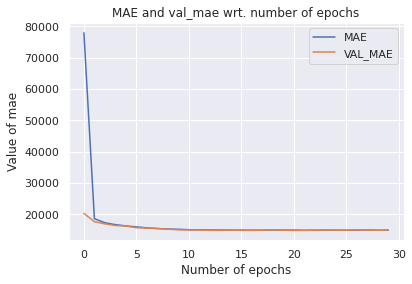

In [324]:
# Plot the training/val losses during training
sns.set_theme()
plt.plot(history.history["mae"], label="MAE")
plt.ylabel("Value of mae")
plt.xlabel("Number of epochs")
# ticks = plt.xticks(np.arange(1, epochs+1))
plt.plot(history.history["val_mae"], label="VAL_MAE")
plt.title("MAE and val_mae wrt. number of epochs")
plt.legend()

In [371]:
model_feature_representation = Model(
    inputs=model.inputs,
    outputs=dense_layer0,
    name="model_feature_representation",
)

In [372]:
X_embedded = model_feature_representation.predict(inputs)

In [381]:
Embedded[:,-1]

array([122000., 175000.,  84000., ..., 150000.,  61000., 133000.])

In [373]:
Embedded = np.hstack([X_embedded,np.reshape(y_train.to_numpy(),(len(y_train),1))])

In [374]:
gm = GaussianMixture(n_components=20, random_state=0,covariance_type='diag').fit(Embedded)

/usr/local/lib/python3.8/dist-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


In [375]:
df_sample = gm.sample(50000)[0]
y_gaussian = df_sample[:,-1]
x_gaussian = df_sample[:,:-1]
regressor = RandomForestRegressor(n_estimators = 30, random_state = 0, max_depth=10)
regressor.fit(x_gaussian, y_gaussian) 

RandomForestRegressor(max_depth=10, n_estimators=30, random_state=0)

In [376]:
y_pred = regressor.predict(x_gaussian)
rmse = float(format(np.sqrt(mean_squared_error(y_pred, y_gaussian)), '.3f'))
print("\nRMSE: ", rmse)


RMSE:  19131.054


In [384]:
y_pred = regressor.predict(Embedded[:,:-1])
y_true = Embedded[:,-1]
rmse = float(format(np.sqrt(mean_squared_error(y_pred, y_true)), '.3f'))
print("\nRMSE: ", rmse)


RMSE:  20910.304
